In [53]:
import numpy as np
from scipy.ndimage import gaussian_filter1d

from numpy.fft import fft, fftshift, fftfreq
from matplotlib import pyplot as plt
import ffmpeg

def get_audio_data(mp4_file):
    probe = ffmpeg.probe(mp4_file)
    audio_stream = next((stream for stream in probe['streams'] 
                        if stream['codec_type'] == 'audio'), None)
    
    if audio_stream is None:
        raise ValueError(f"No audio stream found in {mp4_file}")
    
    sr = int(audio_stream['sample_rate'])
    channels = int(audio_stream['channels'])
    
    out, _ = (
        ffmpeg
        .input(mp4_file)
        .output('-', format='s16le', acodec='pcm_s16le')
        .run(capture_stdout=True, capture_stderr=True)
    )
    
    audio_array = np.frombuffer(out, dtype=np.int16)
    
    if channels > 1:
        audio_array = audio_array.reshape(-1, channels)
        ys = audio_array.mean(axis=1)
    else:
        ys = audio_array
    
    ys = ys / np.iinfo(np.int16).max
    
    num_samples = len(ys)
    ts = np.arange(num_samples) / sr
    
    return ys, ts, sr

def plot_fft(xs, ys):
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Amplitude")
    plt.title("FFT")
    plt.xlim(0, 3000)
    plt.plot(xs, np.abs(ys))
    plt.savefig("FFT Plot")

def plotMagSpec(time_frames, freq_bins, frame_freq_amps):
    plt.figure(figsize=(12, 6))
    plt.subplot(211)
    plt.pcolormesh(time_frames, freq_bins, frame_freq_amps, shading='gouraud')
    plt.title('Magnitude Spectrogram')
    plt.ylabel('Frequency (Hz)')
    plt.xlabel('Time (s)')
    plt.colorbar()
    plt.ylim(0, 3000)

def get_fft(ys, sr):
    n = len(ys)
    
    window = np.hamming(n)

    ys *= window

    scale = 1.0 / np.sum(window) * n

    amps = fft(ys) / n
    amps[1:n//2] *= 2
    amps = amps[:n//2]
    amps *= scale
    freq_bins = fftfreq(n, d=1/sr)[:n//2]
    return freq_bins, amps

In [54]:
def magnitudeSpectrogram(ys, ts, sr):
    fr_len = .002 # 20ms frames
    hop_length = int(sr * fr_len)
    
    frame_freq_amps = []
    time_frames = []

    # Process first frame to get dimensions
    frame_ys = ys[0:hop_length]
    freq_bins, _ = get_fft(frame_ys, sr)
    
    for i in range(0, len(ys) - hop_length + 1, hop_length // 2):
        frame_ys = ys[i:i + hop_length].copy()
        _, amps = get_fft(frame_ys, sr)
        frame_freq_amps.append(np.abs(amps))
        time_frames.append(ts[i + hop_length // 2])
    
    time_frames = np.array(time_frames)
    frame_freq_amps = np.column_stack(frame_freq_amps)
    # plotMagSpec(time_frames=time_frames, freq_bins=freq_bins, frame_freq_amps=frame_freq_amps)
    return time_frames, frame_freq_amps

def computeSpectralFlux(time_frames, frame_freq_amps):
    # note that frame_freq_amps is already magnitude
    spec_flux = np.zeros(len(time_frames) - 1)

    assert(len(time_frames) == len(frame_freq_amps[0]))

    for t in range(1, len(time_frames)):
        flux = 0
        for f in range(len(frame_freq_amps)):
            # we half-wave rectify, so this only computes positive changes in
            flux += frame_freq_amps[f][t] - frame_freq_amps[f][t - 1] 
        spec_flux[t - 1] = flux

    spec_flux = np.array(spec_flux)

    # apply Gaussian filter to smooth
    spec_flux = gaussian_filter1d(spec_flux, sigma=1, truncate=3)

    # half-wave rectify
    spec_flux = np.maximum(spec_flux, 0)
    
    # Normalize spec_flux
    spec_flux /= max(spec_flux)


    return time_frames[1:], spec_flux # skip the first in time_frames due to difference calculation

In [55]:
def differentiate(ys, xs):
    return np.diff(ys) / np.diff(xs)

def detect_onsets(spec_flux, times, threshold=0.15, min_time_between=0.15):
    onsets = []
    
    # Find local maxima above threshold
    for i in range(1, len(spec_flux)-1):
        # Check if it's a local peak above threshold
        if (spec_flux[i] > spec_flux[i-1] and 
            spec_flux[i] >= spec_flux[i+1] and 
            spec_flux[i] > threshold):
            
            # Check timing with previous onset
            if not onsets or (times[i] - onsets[-1]) > min_time_between:
                onsets.append(times[i])
    
    return onsets

before gaussian: 21437
after gaussian: 21437


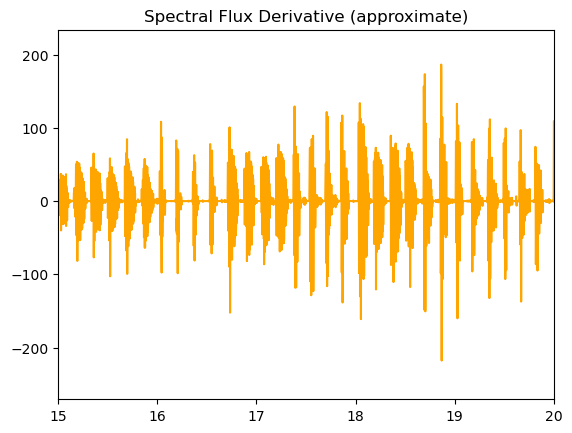

In [56]:
# there are 118 notes articulated within this
ys, ts, sr = get_audio_data("ex6WholeModF.mp4")

ts_fr, fr_freq_amps = magnitudeSpectrogram(ys, ts, sr)
ts_fr, spec_flux = computeSpectralFlux(ts_fr, fr_freq_amps)

plt.plot(ts_fr, spec_flux)
plt.title("Spectral Flux Gaussian Smoothing")
for i in range(4):
    plt.xlim(i * 5, (i + 1) * 5)
    plt.savefig(f"Spectral Flux Gaussian Smoothing, Window {i * 5, (i + 1) * 5}.png")
plt.close()


plt.title("Spectral Flux Derivative (approximate)")
spec_flux_derivative = differentiate(spec_flux, ts_fr)

print(f"before gaussian: {len(spec_flux_derivative)}")
# apply Gaussian filter to smooth
spec_flux_derivative = gaussian_filter1d(spec_flux_derivative, sigma=1, truncate=3)
print(f"after gaussian: {len(spec_flux_derivative)}")

plt.plot(ts_fr[1:], spec_flux_derivative, c="orange")

for i in range(4):
    plt.xlim((i * 5, (i+1) * 5))
    plt.savefig(f"Spectral Flux Derivative (approximate) xlim {i * 5, (i+1) * 5}")


In [59]:
# ys, ts, sr = get_audio_data("ex6_90bpm_1.wav")
# there are 118 notes articulated within this

spec_flux_thresh = .15 # experimentally assumed number for trumpet spectral flux

onsets = detect_onsets(spec_flux, ts_fr)
# print(onsets)
# print(len(onsets))


exerciseNoteCounts = [
    ["ex1WholeMod.mp4", 90],
    ["ex2WholeMod.mp4", 49],
    ["ex6WholeModF.mp4", 118]
]

for exercise, note_count in exerciseNoteCounts:
    ys, ts, sr = get_audio_data(exercise)

    ts_fr, fr_freq_amps = magnitudeSpectrogram(ys, ts, sr)
    ts_fr, spec_flux = computeSpectralFlux(ts_fr, fr_freq_amps)
    onsets = detect_onsets(spec_flux, ts_fr)

    print(f"For exercise {exercise}, Actual: {note_count}, Detected: {len(onsets)}")

For exercise ex1WholeMod.mp4, Actual: 90, Detected: 176
For exercise ex2WholeMod.mp4, Actual: 49, Detected: 209
For exercise ex6WholeModF.mp4, Actual: 118, Detected: 118
